## Using this notebook

This notebook extracts those cropped/shifted/mirrored segments of the positive training examples, and saves them into a new directory. At the very end of the notebook, it uses the [make_training_data_eplorer.sh](./make_training_data_explorer.sh) script to generate html pages on which the resulting datasets can be generated. Those pages are saved to [training/non_smoke.html](./training/non_smoke.html) and [training/smoke_cropped.html](./training/smoke_cropped.html).

After downloading training data from the FireCam project [repository](https://github.com/open-climate-tech/firecam/tree/master/datasets/2019a), it should be extracted and arranged into a directory structure as follows:

```
DataDir
|- bounding_box_data.csv
|- cropped_images/
|- full_images/
   |- img1.jpg
   |- img2.jpg
   |- ...
```

where `img1.jpg`, `img2.jpg`, etc, correspond to images specified in the `Filename` column of `bounding_box_data.csv`. The resulting images will be placed in the `cropped_images` directory with names like `img1_00007_+70,-70_mirror.jpg`, where `00007` denotes the row number from `bounding_box_data.csv`, the box is shifted by (70,-70) pixels, and is mirrored before saving.

The `bounding_box_data.csv` file should contain five rows: `MinX`, `MaxX`, `MinY`, `MaxY`, `Filename`. It is assumed that the file starts with two comment lines, followed by a header line and then the data.

In [1]:
from glob import glob
from os.path import expanduser, join as path_join
from typing import Tuple
from PIL import Image, ImageOps
import pandas as pd

####### CONSTANTS #######
BBOX_DATA  = '~/Data/firecam/2019a-bounding-boxes.csv'
INPUT_DIR  = '~/Data/firecam/smoke_full'
OUTPUT_DIR = '~/Data/firecam/smoke_cropped'
FNAME_PATTERN = '{stem:s}_{idx:d}_{dx:+03d},{dy:+03d}_{orient:s}.jpg'
#########################

bbox = pd.read_csv(expanduser(BBOX_DATA), skiprows=2)
opath = path_join(expanduser(OUTPUT_DIR), FNAME_PATTERN)

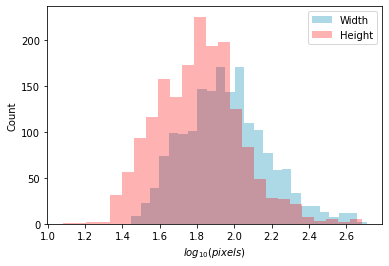

In [2]:
'''
Since we're going to be extracting 299x299 px segments, let's first
check that our bounding boxes have similar dimensions. Ideally, the
bounding boxes will fit comfortably within the cropped images, even
after being shifted as described above.
'''

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(np.log10(bbox.MaxX-bbox.MinX), bins=25, color='lightblue', alpha=1, label='Width')
plt.hist(np.log10(bbox.MaxY-bbox.MinY), bins=25, color='red', alpha=0.3, label='Height')
plt.legend()
plt.xlabel('$log_{10}(pixels)$')
_=plt.ylabel('Count')

In [3]:
class ROI():
    '''
    This class helps with defining and manipulating a
    region of interest within an image's pixel space.
    It includes basic functions for shifting the region
    of interest, and for ensuring that it stays within
    the overall bounds of the image dimensions.
    '''
    def __init__(self, x0: int, y0: int, x1: int, y1: int) -> None:
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
        self.width = x1-x0
        self.height = y1-y0
    
    def shift_x(self, distance: int) -> None:
        self.x1 += distance
        self.x0 += distance
    
    def shift_y(self, distance: int) -> None:
        self.y1 += distance
        self.y0 += distance
    
    def shift_xy(self, dx:int, dy:int) -> None:
        self.shift_x(dx)
        self.shift_y(dy)
    
    def as_tuple(self):
        return (self.x0, self.y0, self.x1, self.y1)
    
    def set_limits(self, limit: Tuple[int, int]) -> None:
        if self.x0 < 0:
            self.shift_x(abs(self.x0))
        if self.y0 < 0:
            self.shift_y(abs(self.y0))
        if self.x1 > limit[0]:
            self.shift_x(self.x1-limit[0])
        if self.y1 > limit[1]:
            self.shift_y(self.y1-limit[1])
        
        assert roi.x0 >= 0
        assert roi.y0 >= 0

In [4]:
## Iterate through the bounding box data rows
for idx, row in bbox.iterrows():
    ## Check whether this image has already been processed
    done = glob(path_join(expanduser(OUTPUT_DIR), row.Filename[:-4]+'*'))
    if len(done) == 10:
        continue
        
    try:
        ipath = path_join(expanduser(INPUT_DIR), row.Filename)
        img = Image.open(ipath)
        # Get center of bounding box
        cx, cy = (row.MinX+row.MaxX)//2, (row.MinY+row.MaxY)//2
        # Choose 5 pixel shift combinations
        offsets = [(0,0), (-70,-70), (-70,70), (70,-70), (70,70)]
        for dx, dy in offsets:
            # Setup a 299x299 ROI centered on (cx+dx,cy+dy)
            roi = ROI(cx-150, cy-150, cx+149, cy+149)
            roi.shift_xy(dx, dy)
            roi.set_limits(img.size)
            cropped = img.crop(roi.as_tuple())
            
            # Save the cropped version and a mirrored copy
            path_args = dict(stem=row.Filename[:-4], idx=idx, dx=dx, dy=dy)
            cropped.save(opath.format(**path_args, orient='normal'))
            ImageOps.mirror(cropped).save(opath.format(**path_args, orient='mirror'))
    except Exception as e:
        print("Unable to process record %s:\n"%row.Filename, e)

Unable to process record pi-s-mobo-c__2019-08-26T10;34;07.jpg:
 [Errno 2] No such file or directory: '/home/jmp/Data/firecam/smoke_full/pi-s-mobo-c__2019-08-26T10;34;07.jpg'


In [5]:
## Put the training data into some html files for
## quick verification that it looks as we'd expect it to.
!./make_training_data_explorer.sh

+ for dataset in non_smoke smoke_cropped
+ SRC=/home/jmp/Data/firecam/non_smoke/
+ BUCKET=s3://storage-9iudgkuqwurq6/firecam/non_smoke/
+ DEST=training/non_smoke.html
++ dirname training/non_smoke.html
+ mkdir -p training
+ s3cmd sync --guess-mime-type --no-mime-magic --delete-removed --acl-public /home/jmp/Data/firecam/non_smoke/ s3://storage-9iudgkuqwurq6/firecam/non_smoke/
+ echo '<html><head><link rel="stylesheet" href="style.css"></head><body>'
+ find /home/jmp/Data/firecam/non_smoke/ -type f -iname '*.jpg'
+ jq -R -r @uri
+ awk '
        { if((NR-1)%10 == 0) print("<div class=\"row\">") };
        { printf("<img src=\"https://storage-9iudgkuqwurq6.s3-us-west-2.amazonaws.com/firecam/%s\" />\n",$1) };
        { if((NR-1)%10==9) print("</div>") }'
+ echo '</body></html>'
+ for dataset in non_smoke smoke_cropped
+ SRC=/home/jmp/Data/firecam/smoke_cropped/
+ BUCKET=s3://storage-9iudgkuqwurq6/firecam/smoke_cropped/
+ DEST=training/smoke_cropped.html
++ dirname training/smoke_cropped.ht